In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
from importlib import reload

# Data processing

In [216]:
# Reading users file
u_cols = ['user_id', 'gender', 'age', 'occupation', 'zip_code']
users = pd.read_csv('/content/drive/MyDrive/Colab/ML/users.dat', sep='::', names=u_cols, encoding='latin-1', engine='python')
n_users = users.shape[0]
n_users

6040

In [217]:
# Reading ratings file
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

ratings_base = pd.read_csv('/content/drive/MyDrive/Colab/ML/ratings.dat', sep='::', names=r_cols, encoding='latin-1', engine='python')
ratings = ratings_base.to_numpy()
rate_train, rate_test = train_test_split(ratings, test_size=0.1, stratify=ratings[:,0])
ratings

array([[        1,      1193,         5, 978300760],
       [        1,       661,         3, 978302109],
       [        1,       914,         3, 978301968],
       ...,
       [     6040,       562,         5, 956704746],
       [     6040,      1096,         4, 956715648],
       [     6040,      1097,         4, 956715569]])

In [218]:
mean = np.array([np.nanmean(rate_train[:,2][np.argwhere(rate_train[:,0]==i+1)]) for i in range(n_users)])

In [219]:
# Reading movies file
i_cols = ['movie id', 'movie title', 'genres']
movies = pd.read_csv('/content/drive/MyDrive/Colab/ML/movies.dat', sep='::', names=i_cols, encoding='latin-1', engine='python')
genres_columns = movies['genres'].str.get_dummies(sep='|')
movies = pd.concat([movies, genres_columns], axis=1)
movies = movies.drop('genres', axis=1)
n_movies = max(movies['movie id'])
n_movies

3952

Handle missing data

In [220]:
#Find and insert missing data to the dataframe with: movie title = 'XXX' and all values in genre column = '0'
existing_ids = movies['movie id'].tolist()
missing_ids = [id for id in range(1, max(existing_ids) + 1) if id not in existing_ids]
missing_data = pd.DataFrame({'movie id': missing_ids, 'movie title': 'XXX'})
missing_data = pd.concat([missing_data, pd.DataFrame(0, index=np.arange(len(missing_data)), columns=genres_columns.columns)], axis=1)
movies = pd.concat([movies, missing_data], ignore_index=True)


# Prediction


In [221]:
#Since we rely on the movie genre to build our profile, we'll only be interested in the 18 binary values at the end of each row:
genre = 18
X0 = movies.to_numpy()
X_train_counts = X0[:, -genre:]
X_train_counts

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=object)

In [222]:
#tfidf
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=True, norm ='l2')
tfidf = transformer.fit_transform(X_train_counts.tolist()).toarray()


def get_items_rated_by_user(rate_matrix, user_id):
    y = rate_matrix[:,0]
    ids = np.where(y == user_id +1)[0]
    item_ids = rate_matrix[ids, 1] - 1
    scores = rate_matrix[ids, 2]
    item_ids = item_ids[np.argsort(scores)]
    scores = sorted(scores)
    return (item_ids[::-1], scores[::-1])

d = tfidf.shape[1] # data dimension
W = np.zeros((d, n_users))
b = np.zeros((1, n_users))




In [223]:
def predict(alpha):
    for n in range(n_users):
        ids, scores = get_items_rated_by_user(rate_train, n)
        clf = Ridge(alpha=alpha, fit_intercept  = True)
        Xhat = tfidf[ids, :]

        clf.fit(Xhat, scores)
        W[:, n] = clf.coef_
        b[0, n] = clf.intercept_
    #Predicted scores
    Yhat = tfidf.dot(W) + b
    return Yhat

# Evaluate model

# Metrics function

In [11]:
def RMSE(Y, rates):
    se = 0
    cnt = 0
    for n in range(n_users):
        ids, scores_truth = get_items_rated_by_user(rates, n)
        scores_pred = Y[ids, n]
        e = scores_truth - scores_pred
        se += (e*e).sum(axis = 0)
        cnt += e.size
    return math.sqrt(se/cnt)

In [12]:
def MAE(Y, rates):
    se = 0
    cnt = 0
    for n in range(n_users):
        ids, scores_truth = get_items_rated_by_user(rates, n)
        scores_pred = Y[ids, n]
        e = abs(scores_truth - scores_pred )
        se += e.sum(axis = 0)
        cnt += e.size
    return math.sqrt(se/cnt)

In [13]:
def metrics(Y):
    tp=0
    tp_fp=0
    tp_fn=0
    para = 0
    for r in rate_test:
        trueRate = r[2]-mean[r[0]-1]
        predictRate = Y[r[1]-1,r[0]-1]-mean[r[0]-1]
        if predictRate>para:
            tp_fp+=1
        if trueRate>para:
            tp_fn += 1
            if predictRate>para:
                tp+=1
    precision = tp/tp_fp
    recall = tp/tp_fn
    f1 = 2*precision*recall/(precision+recall)
    return (precision, recall,f1)

In [15]:
def PrecisionAtK(Y,K):
    Y=Y.T
    rcm_movie_test = np.argsort(-(user_item_test))
    rcm_movie = np.argsort(-Y)
    precisionK=[]
    recallK=[]
    f1K=[]
    mapK=[]
    marK=[]
    for u in range(n_users):
        rcm = rcm_movie[u]
        rcm = rcm[np.argwhere(Y[u][rcm] > mean[u])]
        rcm_test = rcm_movie_test[u][np.in1d(rcm_movie_test[u], np.argwhere(~np.isnan(user_item_test[u])))]
        rcm = np.intersect1d(rcm, rcm_test)
        rcm_test = rcm_test[np.argwhere(user_item_test[u][rcm_test] > mean[u])]
        rcm = rcm[:K]

        precision=np.in1d(rcm,rcm_test)
        recall=np.in1d(rcm_test,rcm)

        map=[]
        for k in range(len(rcm)):
            p = np.mean(precision[:k+1])*precision[k]
            if p>0:
                map.append(p)

        mar=[]
        for k in range(len(rcm_test)):
            r = np.mean(recall[:k+1])*recall[k]
            if r>0:
                mar.append(r)

        precision=np.mean(precision)
        recall=np.mean(recall)
        f1=0
        if precision + recall != 0:
            f1 = 2*precision*recall/(precision+recall)
        precisionK.append(precision)
        recallK.append(recall)
        f1K.append(f1)
        mapK.append(np.mean(map))
        marK.append(np.mean(mar))

    precisionK=np.nan_to_num(precisionK)
    recallK=np.nan_to_num(recallK)
    f1K=np.nan_to_num(f1K)
    mapK=np.nan_to_num(mapK)
    marK=np.nan_to_num(marK)

    return (np.mean(precisionK), np.mean(recallK), np.mean(f1K), np.mean(mapK), np.mean(marK))

In [16]:
def NDCG(Y,K):
    Y = Y.T
    rcm_movie_test = np.argsort(-(user_item_test))
    rcm_movie = np.argsort(Y)
    ndcg=[]
    for u in range(n_users):
        dcg=0
        idcg=0
        rcm_test = rcm_movie_test[u][np.in1d(rcm_movie_test[u], np.argwhere(~np.isnan(user_item_test[u])))]
        rcm = rcm_movie[u][np.in1d(rcm_movie[u], rcm_test)]
        for i in range(len(rcm[:K])):
            dcg += (2**user_item_test[u][rcm[i]]-1)/math.log(i+2, 2)
            idcg += (2**user_item_test[u][rcm_test[i]]-1)/math.log(i+2, 2)
        ndcg.append(dcg/idcg)
    return np.mean(ndcg)

In [17]:
user_item = np.full((n_users,n_movies),np.nan)
for r in rate_train:
    user_item[r[0]-1][r[1]-1] = r[2]

user_item_test = np.full((n_users,n_movies),np.nan)
for r in rate_test:
    user_item_test[r[0]-1][r[1]-1] = r[2]
user_item_test

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [ 3., nan, nan, ..., nan, nan, nan]])

# Test for lambda

In [18]:
rmse_train = []
rmse_test =[]
mae_train=[]
mae_test=[]
precision=[]
recall=[]
f1=[]
iteration_list = [0.001, 0.01, 0.1, 0.5, 1, 5, 15, 30, 50]

for a in iteration_list:
    Yhat = predict(a)
    rmse_train.append(RMSE(Yhat, rate_train))
    rmse_test.append(RMSE(Yhat, rate_test))
    mae_train.append(MAE(Yhat, rate_train))
    mae_test.append(MAE(Yhat, rate_test))
    metric = metrics(Yhat)
    precision.append(metric[0])
    recall.append(metric[1])
    f1.append(metric[2])
    ndcg.append(NDCG(Yhat,10000))

RMSE:  [0.9695890276797524, 0.969658813621179, 0.9707498418131624, 0.9749535118246381, 0.9789089144963907, 0.9942518917078855, 1.0067725113889416, 1.0136168907573686, 1.017708585827658]
RMSE:  [1.109687392499896, 1.1037260273954124, 1.0876590240040611, 1.0697766588214452, 1.0612753468760148, 1.0443554683290441, 1.0376238274507286, 1.0354212148780872, 1.0345346443347516]


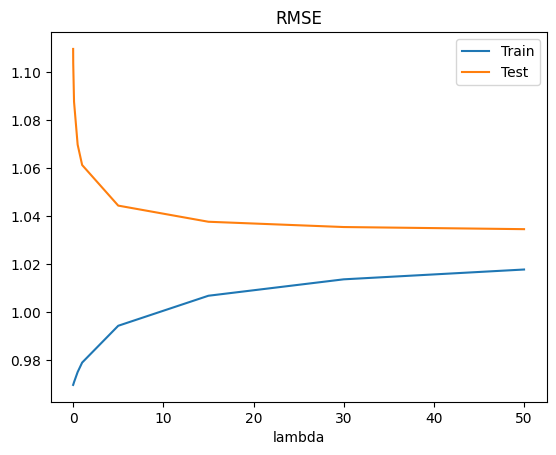

In [19]:
import matplotlib.pyplot as plt
from importlib import reload
print("RMSE: ",rmse_train)
print("RMSE: ",rmse_test)
plt=reload(plt)
plt.plot(iteration_list, rmse_train, label = 'Train')
plt.plot(iteration_list, rmse_test, label = 'Test')
plt.xlabel('lambda')
plt.title('RMSE')
plt.legend()
plt.show()

Precision:  [0.5488107398219758, 0.5487223275090072, 0.5489063830671126, 0.5483289849670766, 0.5482115245850944, 0.5472839077407097, 0.5473379957149209, 0.5474956476497309, 0.5477392905947359]
Recall:  [0.4857469695012823, 0.4861344305245484, 0.48757357146810826, 0.4885883503385671, 0.49061790807948485, 0.4942711120131368, 0.4996217642391926, 0.5048063617409916, 0.5102861676414694]
F1:  [0.5153567583439366, 0.5155357282617202, 0.516425319028356, 0.5167377284302341, 0.5178181959806823, 0.5194283941520922, 0.522392522643311, 0.5252851054026034, 0.5283498261567264]


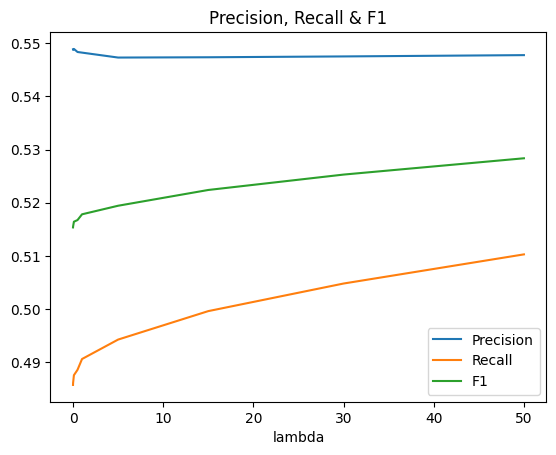

In [20]:
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1)
plt=reload(plt)
plt.plot(iteration_list, precision, label = 'Precision')
plt.plot(iteration_list, recall, label ='Recall')
plt.plot(iteration_list, f1,label='F1')
plt.xlabel('lambda')
plt.title('Precision, Recall & F1')
plt.legend()
plt.show()

# Test for number of movies

In [63]:
PRECISION=[]
RECALL=[]
F11=[]
NDCGG=[]
MAPP=[]
MARR=[]

In [ ]:
precision=[]
recall=[]
f1=[]
ndcg=[]
map=[]
mar=[]
num_movie = [5, 15, 30, 50, 100]
Yhat = predict(10)
for num in num_movie:
    metric = PrecisionAtK(Yhat,num)
    precision.append(metric[0])
    recall.append(metric[1])
    f1.append(metric[2])

    ndcg.append(NDCG(Yhat,num))

    map.append(metric[3])
    mar.append(metric[4])

PRECISION.append(precision)
RECALL.append(recall)
F11.append(f1)
NDCGG.append(ndcg)
MAPP.append(map)
MARR.append(mar)

Precision:  [0.64280824 0.63507716 0.63328656 0.63304647 0.6329938 ]
Recall:  [0.45380568 0.56398212 0.58851655 0.59312439 0.59382459]
F1:  [0.48354215 0.563956   0.57958741 0.58218996 0.5825417 ]


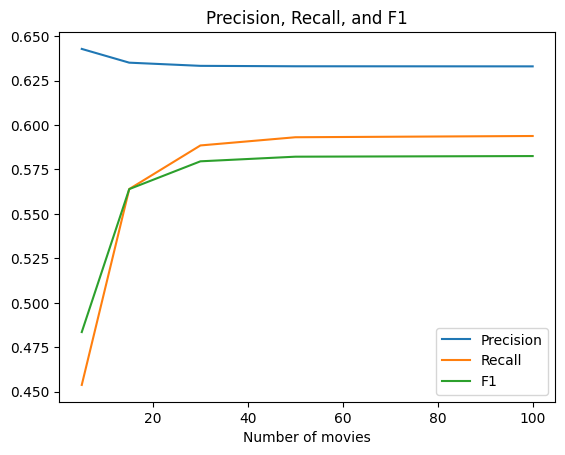

In [237]:
print("Precision: ",np.mean(PRECISION, axis=0))
print("Recall: ",np.mean(RECALL, axis=0))
print("F1: ",np.mean(F11, axis=0))
plt=reload(plt)
plt.plot(num_movie, np.mean(PRECISION, axis=0), label = 'Precision')
plt.plot(num_movie, np.mean(RECALL, axis=0), label ='Recall')
plt.plot(num_movie, np.mean(F11, axis=0),label='F1')
plt.xlabel('Number of movies')
plt.title('Precision, Recall, and F1')
plt.legend()
plt.show()


MAP:  [0.74412924 0.7286725  0.72692367 0.72673366 0.72672824]
MAR:  [0.58343298 0.67156969 0.69216103 0.69619535 0.6968502 ]
NDCG:  [0.6047675  0.71971271 0.7657293  0.78375151 0.79196974]


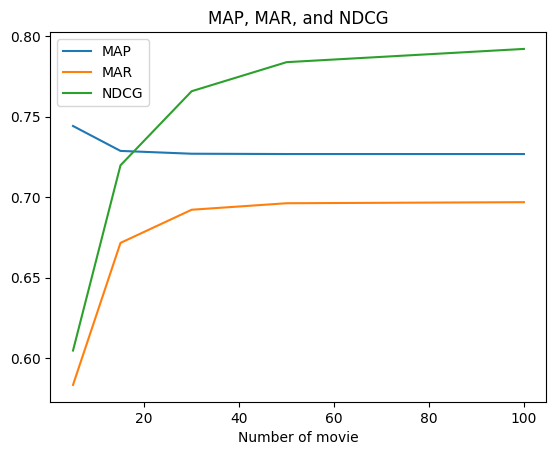

In [238]:
print("MAP: ",np.mean(MAPP, axis=0))
print('MAR: ', np.mean(MARR, axis=0))
print('NDCG: ', np.mean(NDCGG, axis=0))
plt=reload(plt)
plt.plot(num_movie, np.mean(MAPP, axis=0), label='MAP')
plt.plot(num_movie, np.mean(MARR, axis=0), label='MAR')
plt.plot(num_movie, np.mean(NDCGG, axis=0), label='NDCG')
plt.xlabel('Number of movie')
plt.title('MAP, MAR, and NDCG')
plt.legend()
plt.show()
